The purpose of this exercise is to create a churn model to predict whether a customer will unsubscribe from their mobile service. 

In [23]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('PROFILE_CALLS.csv')
df.head()

,subs_no,Telephone_no,MRC,MODEL_GROUP_NM,COMMIT_START_DT,Bill_Payments,Mobility_Technical_Support,Account_Management,Upgrades,Escalations,Cancellation,Average_Handle_Time
0,11139950,6132855152,65.00,Apple Iphone 8 64gb64GB,30-Jun-18,0,0,0,0,0,0,236.0
1,11139950,6132855152,65.00,Apple Iphone 8 64gb64GB,30-Jun-18,0,2,0,0,0,0,236.0
2,11141427,4169315521,49.50,Apple Iphone 8 64gb64GB,30-Jun-18,0,0,1,0,0,0,697.0
3,11141604,5148129653,90.46,Apple Iphone 8 64gb64GB,30-Jun-18,1,0,0,0,0,0,557.0
4,11141695,3657783316,91.00,Apple Iphone X 64gb64GB,30-Jun-18,0,0,0,0,0,0,213.5


Feature Engineering, by creating a new feature by finding how long the customer has been on their contract for.

In [3]:
df['COMMIT_START_DT'] = pd.to_datetime(df['COMMIT_START_DT'])
df['On_Contract_For_Months'] = (datetime.now() - df['COMMIT_START_DT']) // np.timedelta64(1, 'M')
df = df.drop(columns = ['COMMIT_START_DT'])
df.head()

,subs_no,Telephone_no,MRC,MODEL_GROUP_NM,Bill_Payments,Mobility_Technical_Support,Account_Management,Upgrades,Escalations,Cancellation,Average_Handle_Time,On_Contract_For_Months
0,11139950,6132855152,65.00,Apple Iphone 8 64gb64GB,0,0,0,0,0,0,236.0,13
1,11139950,6132855152,65.00,Apple Iphone 8 64gb64GB,0,2,0,0,0,0,236.0,13
2,11141427,4169315521,49.50,Apple Iphone 8 64gb64GB,0,0,1,0,0,0,697.0,13
3,11141604,5148129653,90.46,Apple Iphone 8 64gb64GB,1,0,0,0,0,0,557.0,13
4,11141695,3657783316,91.00,Apple Iphone X 64gb64GB,0,0,0,0,0,0,213.5,13


The first step is to perform EDA and test different models to see what works and doesnt work.

In [4]:
#group phones into phone or android
def Iphone_Android(x):
    x = str(x)
    if x.find('iphone') != -1 or x.find('Iphone') != -1:
        model = 'Iphone'
    else:
        model = 'Android'
    return model
        
df['Model_Type'] = df['MODEL_GROUP_NM'].apply(Iphone_Android)
df.head()

,subs_no,Telephone_no,MRC,MODEL_GROUP_NM,Bill_Payments,Mobility_Technical_Support,Account_Management,Upgrades,Escalations,Cancellation,Average_Handle_Time,On_Contract_For_Months,Model_Type
0,11139950,6132855152,65.00,Apple Iphone 8 64gb64GB,0,0,0,0,0,0,236.0,13,Iphone
1,11139950,6132855152,65.00,Apple Iphone 8 64gb64GB,0,2,0,0,0,0,236.0,13,Iphone
2,11141427,4169315521,49.50,Apple Iphone 8 64gb64GB,0,0,1,0,0,0,697.0,13,Iphone
3,11141604,5148129653,90.46,Apple Iphone 8 64gb64GB,1,0,0,0,0,0,557.0,13,Iphone
4,11141695,3657783316,91.00,Apple Iphone X 64gb64GB,0,0,0,0,0,0,213.5,13,Iphone


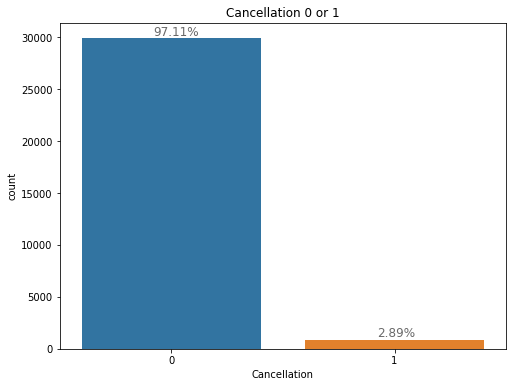

In [5]:
#find the split between cancel and not cancel, and the percentage of each
fig, ax = plt.subplots(1, 1, figsize = (8,6))
sns.countplot(df['Cancellation'], ax= ax)
ax.set_title('Cancellation 0 or 1')
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+0.32, i.get_height()+300, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=12,
color='dimgrey')


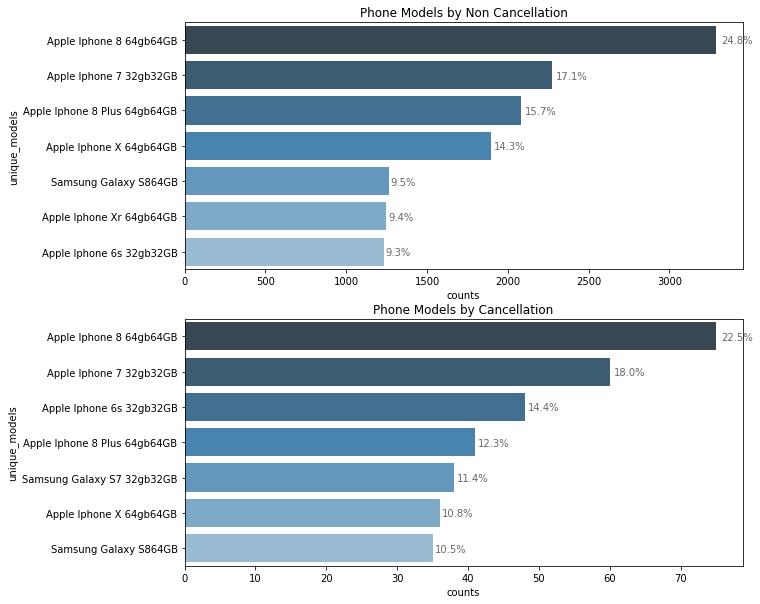

In [6]:
#value_counts for model when they do not cancel
df_0 = df[df['Cancellation']==0]
model_counts = df_0['MODEL_GROUP_NM'].value_counts()
model_counts = model_counts.rename_axis('unique_models').to_frame('counts')
model_counts_filtered_0 = model_counts[model_counts['counts']> 1000].reset_index()

#value_counts for model when they do cancel
df_1 = df[df['Cancellation']==1]
model_counts = df_1['MODEL_GROUP_NM'].value_counts()
model_counts = model_counts.rename_axis('unique_models').to_frame('counts')
model_counts_filtered_1 = model_counts[model_counts['counts']> 30].reset_index()

fig, ax = plt.subplots(2, 1, figsize = (10,10))
sns.barplot(y ='unique_models' ,x =  'counts',data = model_counts_filtered_0, palette="Blues_d", ax= ax[0])
sns.barplot(y ='unique_models' ,x =  'counts',data = model_counts_filtered_1, palette="Blues_d", ax= ax[1])
ax[0].set_title('Phone Models by Non Cancellation')
ax[1].set_title('Phone Models by Cancellation')

for axes in [0,1]:
    total = 0 
    totals = []
#create the labels for 
# find the values and append to list
    for i in ax[axes].patches:
        totals.append(i.get_width())

# set individual bar lables using above list
    total = sum(totals)

# set individual bar lables using above list
    for i in ax[axes].patches:
    # get_width pulls left or right; get_y pushes up or down
        ax[axes].text(i.get_width()*1.01,i.get_y()+0.50,  \
                str(round((i.get_width()/total)*100,1))+'%', fontsize=10,
                color='dimgrey')

Text(0.5, 1.0, 'Top 10 Area Codes')

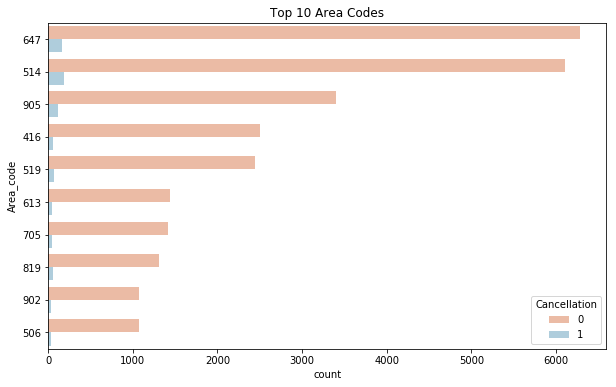

In [7]:
#extract the area code from the telephone number
df['Area_code'] = df['Telephone_no'].astype(str).str[:3]

fig, ax = plt.subplots(1, 1, figsize = (10,6))
sns.countplot(y = 'Area_code',data = df, palette="RdBu", ax= ax, orient = 'h', hue = 'Cancellation', order = df['Area_code'].value_counts().index[:10])
ax.set_title('Top 10 Area Codes')

C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


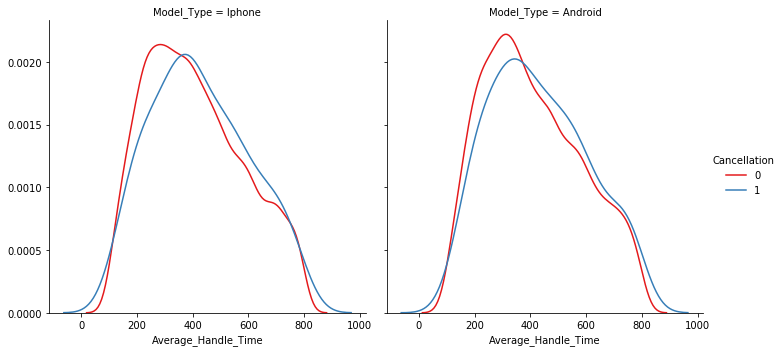

In [8]:
df_shorter_aht = df[(df['Average_Handle_Time']<800) &  (df['Average_Handle_Time']>100) ]

g = sns.FacetGrid(df_shorter_aht, col ="Model_Type",hue="Cancellation", palette="Set1", size = 5)
g = g.map(sns.distplot, "Average_Handle_Time", hist=False)
g.add_legend()

Text(0.5, 1.0, 'MRC vs Cancellation')

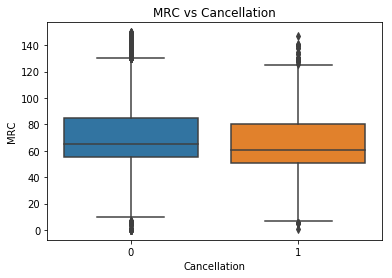

In [9]:
#how does the monthly recurring charge change from cancel and not cancel
df_shorter_aht = df[(df['MRC']<150)]
ax = sns.boxplot(x="Cancellation", y="MRC", data=df_shorter_aht)
ax.set_title('MRC vs Cancellation')

In [10]:
df.columns

Index(['subs_no', 'Telephone_no', 'MRC', 'MODEL_GROUP_NM', 'Bill_Payments',
       'Mobility_Technical_Support', 'Account_Management', 'Upgrades',
       'Escalations', 'Cancellation', 'Average_Handle_Time',
       'On_Contract_For_Months', 'Model_Type', 'Area_code'],
      dtype='object')

There are a lot more non cancellation than cancellation subscribers. Therefore, I am going to first split the dataset into train and test and then oversample the minority (cancellation calls) from the train set. I will not oversample the test. Oversampling is done with the sklearn package resample. 

In [11]:
#balancing the cancel to non cancel ratio 
X = df[['On_Contract_For_Months','MRC','Bill_Payments', 'Mobility_Technical_Support', 'Account_Management','Upgrades', 'Escalations','Average_Handle_Time', 'Model_Type']]
y = df[['Cancellation']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_cancel = X[X['Cancellation']==0]
cancel = X[X['Cancellation']==1]

# upsample minority
cancel_upsampled = resample(cancel,
                          replace=True, # sample with replacement
                          n_samples=len(not_cancel), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_cancel, cancel_upsampled])

# check new class counts
upsampled['Cancellation'].value_counts()

1    22434
0    22434
Name: Cancellation, dtype: int64

Since there is a mix between numeric and categorical features. I have created a make_column_transformer pipelines where numerical features will get standardscaler, and categorial_features will get onehotenocodered. Everything else will just pass through as is. 

In [12]:
#preprocessing the data before the model fitting 

x_upsampled_train = upsampled[['On_Contract_For_Months','MRC','Bill_Payments', 'Mobility_Technical_Support', 'Account_Management','Upgrades', 'Escalations', 'Average_Handle_Time', 'Model_Type']]
y_upsampled_train = upsampled[['Cancellation']]
                 
numerical_features = ['MRC','Average_Handle_Time','On_Contract_For_Months']
categorical_features = ['Model_Type']
preprocess = make_column_transformer((numerical_features, StandardScaler()),(categorical_features, OneHotEncoder()), remainder ='passthrough')
pre_x_train = preprocess.fit_transform(x_upsampled_train)
pre_x_test = preprocess.transform(X_test)

C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:732: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\

I am interested to see how the data is seperated between cancel and non cancel after a T SNE transformation

Text(0.5, 1.0, 'T-SNE between Cancel and not Cancel')

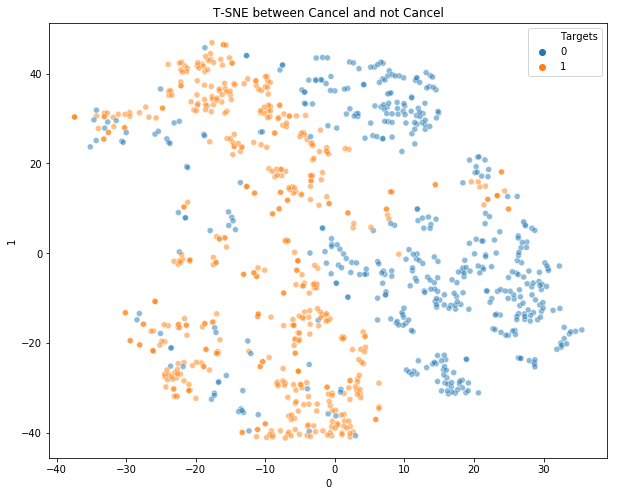

In [13]:
#T-SNE dimension reduction to see where are the Cancel and Non Cancel data lie
t_sne = pd.DataFrame(data= pre_x_train)
t_sne['y_train'] = np.array(y_upsampled_train)
t_sne = t_sne.sample(1000)

X_embedded = TSNE(n_components=2).fit_transform(t_sne.iloc[:,:-1])
tsne_df = pd.DataFrame(X_embedded)
tsne_df['Targets'] = np.array(t_sne['y_train'])

fig,ax = plt.subplots(1,1, figsize=(10,8))
sns.scatterplot(x=0, y=1, data =tsne_df, hue = 'Targets', alpha = 0.5)
ax.set_title('T-SNE between Cancel and not Cancel')

Now, it is time to try out different models and do a grid search on each to iteration through different hyperparameters. The full_classification_report, is a report that prints out the best params, other params and its score, the ROC, and also classification report. 

In [14]:
def full_classification_report(model, param, pre_x_train,y_upsampled_train,pre_x_test,y_test):
#trains the model using train x and train y
#grid search through the different hyperparameters defined in param
    grid_search = GridSearchCV(estimator = model, param_grid = param, cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(pre_x_train,y_upsampled_train)
    best_estimator = grid_search.best_estimator_
    y_pred = grid_search.predict(pre_x_test)
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    params = grid_search.cv_results_['params']
    
#this prints out the classification report (y predicted vs y actuals from the test set)
    print()
    print("This is the classification report:", 'Best Paramters',grid_search.best_params_ )
    print(classification_report(y_test, y_pred))
    
#this is the ROC curve, AUC is also printed
    print("This is a ROC:")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('AUC: %f' %auc)
    plt.show()
    print()
#this shows all the other grid search results
    print('Other Gridsearch Results:')
    for mean, std, params in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    return best_estimator

Run a random forest classifer to see the results:

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.5min finished
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)



This is the classification report: Best Paramters {'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 120}
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7473
           1       0.53      0.89      0.67       227

   micro avg       0.97      0.97      0.97      7700
   macro avg       0.76      0.93      0.83      7700
weighted avg       0.98      0.97      0.98      7700

This is a ROC:


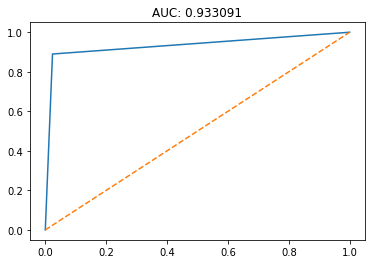


Other Gridsearch Results:
0.986 (+/-0.001) for {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
0.986 (+/-0.001) for {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 120}
0.986 (+/-0.001) for {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
0.986 (+/-0.002) for {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 120}
0.984 (+/-0.002) for {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 100}
0.984 (+/-0.002) for {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 120}
0.984 (+/-0.002) for {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
0.984 (+/-0.002) for {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 4, 'min_sa

In [15]:
param = {'max_depth': [80, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 120]}

model = RandomForestClassifier()
random_forest_best = full_classification_report(model, param, pre_x_train,y_upsampled_train,pre_x_test,y_test)

Run a SVC model and see what the results are: 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.2min remaining:   20.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.4min finished
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



This is the classification report: Best Paramters {'C': 100}
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      7473
           1       0.40      0.88      0.55       227

   micro avg       0.96      0.96      0.96      7700
   macro avg       0.70      0.92      0.76      7700
weighted avg       0.98      0.96      0.97      7700

This is a ROC:


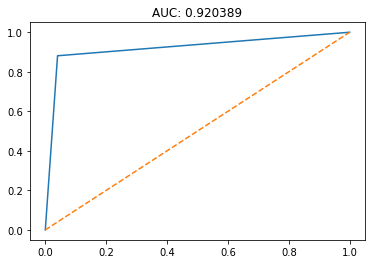


Other Gridsearch Results:
0.978 (+/-0.002) for {'C': 1}
0.979 (+/-0.002) for {'C': 10}
0.980 (+/-0.002) for {'C': 100}


In [16]:
param = {'C':[1,10,100]}
model = SVC()
svc_best = full_classification_report(model, param, pre_x_train,y_upsampled_train,pre_x_test,y_test)

Run a Logistic regression to see what are the results:

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.7s finished
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



This is the classification report: Best Paramters {'C': 100}
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      7473
           1       0.39      1.00      0.56       227

   micro avg       0.95      0.95      0.95      7700
   macro avg       0.69      0.98      0.77      7700
weighted avg       0.98      0.95      0.96      7700

This is a ROC:


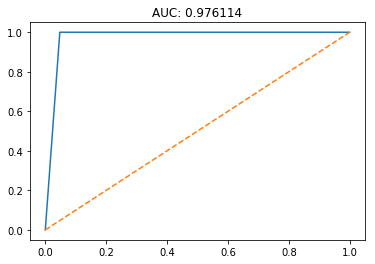


Other Gridsearch Results:
0.977 (+/-0.001) for {'C': 1}
0.977 (+/-0.001) for {'C': 10}
0.977 (+/-0.001) for {'C': 100}


In [17]:
param_grid = {'kernel':['linear', 'poly', 'rbf']}
model = LogisticRegression()
logistic_best = full_classification_report(model, param, pre_x_train,y_upsampled_train,pre_x_test,y_test)

In [21]:
ensemble = VotingClassifier(estimators=[('RF', random_forest_best), ('svcrf', svc_best), ('lr', logistic_best)], voting='hard')
ensemble = ensemble.fit(pre_x_train, y_upsampled_train)
y_pred = ensemble.predict(pre_x_test)

print("This is the classification report for the ensemble:")
print(classification_report(y_test, y_pred))

C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


This is the classification report for the ensemble:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      7473
           1       0.41      0.97      0.58       227

   micro avg       0.96      0.96      0.96      7700
   macro avg       0.70      0.97      0.78      7700
weighted avg       0.98      0.96      0.97      7700



###  Based on all the results: The ensemble with random forest, SVC, and logistic regression will be the best results. The trade off between recall and precision means the model is able find 97% of the cancellations from all the true cancellations. and precision of 41% means out of everything I have predicted as cancel, almost half of it is correct. The business decision is ok with the lower precision because if we give more people loyality offers, it just improves customer satisfication. 

After the EDA and testing what model works. The next step is to create a clean and reusable pipeline to be deployed into production. 

In [22]:
numerical_features = ['MRC','Average_Handle_Time','On_Contract_For_Months']
categorical_features = ['Model_Type']


preprocessor = make_column_transformer((numerical_features, StandardScaler()),(categorical_features, OneHotEncoder()), remainder ='passthrough')
ensemble = VotingClassifier(estimators=[('RF', random_forest_best), ('svcrf', svc_best), ('lr', logistic_best)], voting='hard')

final_model = Pipeline(steps=[('preprocessor', preprocessor),\
                    ('classifier', ensemble)])
                  
final_model.fit(x_upsampled_train, y_upsampled_train)
final_model.score(X_test,y_test)
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:732: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklea

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      7473
           1       0.41      0.97      0.57       227

   micro avg       0.96      0.96      0.96      7700
   macro avg       0.70      0.97      0.78      7700
weighted avg       0.98      0.96      0.97      7700



# Pickle the final model

In [27]:
filename = 'finalized_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
print(result[0:20])


C:\Users\aaronmok\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
